In [1]:
# Change working directory
os.chdir('/Users/suongsuong/Documents/GitHub/Reactivity-based-metric-of-complexity/Reduction of ketone/')

import pandas as pd
from count_view_Reaction import *

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import GraphDescriptors

from calculate_published_features.bottchscore3 import *      #developed by Forli Lab https://github.com/forlilab/bottchscore
import calculate_published_features.spacial_score as sps     #from GitHub page of published paper https://github.com/frog2000/Spacial-Score
from calculate_published_features.pychem.src.pychem.topology import * # from https://github.com/cosylabiiit/chemopy?tab=readme-ov-file

import ast
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data_wSterimol_PBV = pd.read_excel('ReductionKetone_get_Sterimol_PBV.xlsx')
count_num_reaction(data_wSterimol_PBV)

# turn following columns from objects to list of string
data_wSterimol_PBV['Reactant SMILES'] = data_wSterimol_PBV['Reactant SMILES'].apply(ast.literal_eval)
data_wSterimol_PBV['Product SMILES'] = data_wSterimol_PBV['Product SMILES'].apply(ast.literal_eval)

Number of Reactions: 906


# <span style="color:blue"> Some Basic features </span>

In [4]:
def count_HA(smiles: str) -> int:
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        raise ValueError("Invalid SMILES string")
    
    Num_heteroatoms = 0
    for atom in molecule.GetAtoms():
        if atom.GetAtomicNum() not in [1, 6]: 
            Num_heteroatoms += 1
    return Num_heteroatoms

def count_sp3_C(smiles: str) -> int:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    Num_sp3_carbons = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6 and atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3:
            Num_sp3_carbons += 1
    return Num_sp3_carbons

def count_C(smiles: str) -> int:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    Num_carbons = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            Num_carbons += 1
    return Num_carbons

def count_stereogenic_C(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    Num_chiral_centers = rdMolDescriptors.CalcNumAtomStereoCenters(mol)
    return Num_chiral_centers

def count_NumRing(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    NumRing = rdMolDescriptors.CalcNumRings(mol)
    return NumRing

def count_Num_aroRing(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    Num_aroRing = rdMolDescriptors.CalcNumAromaticRings(mol)
    return Num_aroRing

In [5]:
def get_basic_features(data, col_smiles):
    data = data.copy()
    data['Ring'] = data.apply(lambda x: count_NumRing( x[col_smiles][0]), axis=1)
    data['aroma_Ring'] = data.apply(lambda x: count_Num_aroRing( x[col_smiles][0]), axis=1)

    data['Carbons'] = data.apply(lambda x: count_C( x[col_smiles][0]), axis=1)
    data['Chiral Carbons'] = data.apply(lambda x: count_stereogenic_C( x[col_smiles][0]), axis=1)

    data['sp3 Carbons'] = data.apply(lambda x: count_sp3_C( x[col_smiles][0]), axis=1)
    data['HA'] = data.apply(lambda x: count_HA( x[col_smiles][0]), axis=1)

    return data


# <span style="color:blue"> Some published index: Cm, SPS, Fsp3, FCstereo, CT </span>


In [6]:
def calculate_bertz_index(smiles):
    # Parse the SMILES string to create a molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    bertz_index = GraphDescriptors.BertzCT(mol)
    return bertz_index

def get_published_index(data, col_smiles):
    data['Cm'] = data.apply(lambda x: calculate_bottchscore_from_smiles( x[col_smiles][0],verbose_response=False, debug_arg=False, disable_mesomer=False, automorp_memory_maxsize=3000000), axis=1)
    data['Cm/HA'] = data.apply(lambda x: x['Cm']/x['HA'], axis=1)

    data['SPS'] = data.apply(lambda x: sps.calculate_score_from_smiles(x[col_smiles][0], per_atom=False), axis=1)
    data['nSPS'] = data.apply(lambda x:sps.calculate_score_from_smiles(x[col_smiles][0], per_atom=True), axis=1)

    data['F_sp3'] = data.apply(lambda x: x['sp3 Carbons']/x['Carbons'], axis=1)
    data['F_Cstereo'] = data.apply(lambda x: x['Chiral Carbons']/x['Carbons'], axis=1)
    
    data['C_T'] = data.apply(lambda x: calculate_bertz_index(x[col_smiles][0]), axis=1)

    return data

# <span style="color:blue"> Some topological index </span>

In [7]:
def get_topology_index(data, col_smiles):
    
    data['Harary'] = data.apply(lambda x: CalculateHarary(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)
    data['GraphDistance'] = data.apply(lambda x: CalculateGraphDistance(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)
    data['Diameter'] = data.apply(lambda x: CalculateDiameter(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)
    data['Platt'] = data.apply(lambda x: CalculatePlatt(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)
    data['SimpleTopo'] = data.apply(lambda x: CalculateSimpleTopoIndex(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)
    data['GeometricTopo'] = data.apply(lambda x: CalculateGeometricTopoIndex(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)
    data['ArithmeticTopo'] = data.apply(lambda x: CalculateArithmeticTopoIndex(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)
    data['MolSizeTotalInf'] = data.apply(lambda x: CalculateMolSizeTotalInf(Chem.MolFromSmiles(x[col_smiles][0])), axis=1)

    return data

# <span style="color:blue"> Some parameters at alpha position </span>

In [ ]:
def find_alpha_carbon_index(smiles, carbonyl_C_index):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")

    atom = mol.GetAtomWithIdx(carbonyl_C_index - 1) #index in table counting from 1
    atom_neighbors = atom.GetNeighbors()

    alpha_atom_indices = []
    for neighbor in atom_neighbors:
        if neighbor.GetSymbol() != 'O':
            bond = mol.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            if bond and bond.GetBondType() != Chem.BondType.DOUBLE:  #not getting the oxygen of the carbonyl
                neighbor_symbol = neighbor.GetSymbol()
                neighbor_idx = neighbor.GetIdx() + 1
                neighbor_info = [neighbor_symbol,neighbor_idx]
                alpha_atom_indices.append(neighbor_info) 
    return alpha_atom_indices #return a list of [atom, idx]

In [ ]:
def get_subs_group_atAlpha(smiles, index):
    # Parse the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    index -= 1#  Convert index to 0-based if necessary (RDKit uses 0-based indexing)
    atom = mol.GetAtomWithIdx(index)

    # Count the number of bond on alpha position
    num_bonds = atom.GetDegree()
    if num_bonds == 4:
        return 4 - 1 #minus 1 of the main branch
    elif num_bonds == 3:
        return 3 - 1
    elif num_bonds == 2:
        return 2 - 1 
    elif num_bonds == 1:
        return 0
    else:
        raise ValueError(smiles, "Number of substituent groups cannot be determined")

def get_isAromatic_atAlpha(smiles, index_list):
    # Parse the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    is_aromatic = 0
    for index in index_list:
        index -= 1 #  Convert index to 0-based if necessary (RDKit uses 0-based indexing)
        atom = mol.GetAtomWithIdx(index) 

        if atom.GetIsAromatic():# Check for aromaticity
            is_aromatic += 1
        else:
            is_aromatic += 0
    return is_aromatic

#### collumn 'Is Aromatic?':
if both alpha position has aromatic ring, Is Aromatic? = 2.
if only 1 alpha position has aromatic ring, Is Aromatic? = 1.
else Is Aromatic? = 0.

In [86]:
def get_alpha_info(data):
    data['C_alpha_indexes'] = data.apply(lambda x: find_alpha_carbon_index(x['Reactant smiles map'], x['C_idx']), axis=1)
    data['C_alpha_index 1'] = data.apply(lambda x: x['C_alpha_indexes'][0][1], axis = 1)
    data['C_alpha_index 2'] = data.apply(lambda x: x['C_alpha_indexes'][1][1], axis = 1)

    data['Is Aromatic?'] = data.apply(lambda x: get_isAromatic_atAlpha(x['Reactant smiles map'], [x['index 1'],x['index 2']]), axis=1)
    data['Number sub group at index 1'] = data.apply(lambda x: get_subs_group_atAlpha(x['Reactant smiles map'], x['index 1']), axis=1)
    data['Number sub group at index 2'] = data.apply(lambda x: get_subs_group_atAlpha(x['Reactant smiles map'], x['index 2']), axis=1)

-----
### Calculation

In [8]:
data_getFeatures_Reactants = data_wSterimol_PBV.copy()
data_getFeatures_Reactants = get_basic_features(data_getFeatures_Reactants, 'Reactant SMILES')
data_getFeatures_Reactants = get_published_index (data_getFeatures_Reactants, 'Reactant SMILES')
data_getFeatures_Reactants = get_topology_index (data_getFeatures_Reactants, 'Reactant SMILES')
data_getFeatures_Reactants = get_alpha_info(data_getFeatures_Reactants)

data_getFeatures_Product = data_wSterimol_PBV.copy()
data_getFeatures_Product = get_basic_features(data_getFeatures_Product, 'Product SMILES')
data_getFeatures_Product = get_published_index (data_getFeatures_Product, 'Product SMILES')
data_getFeatures_Product = get_topology_index (data_getFeatures_Product, 'Product SMILES')

*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...


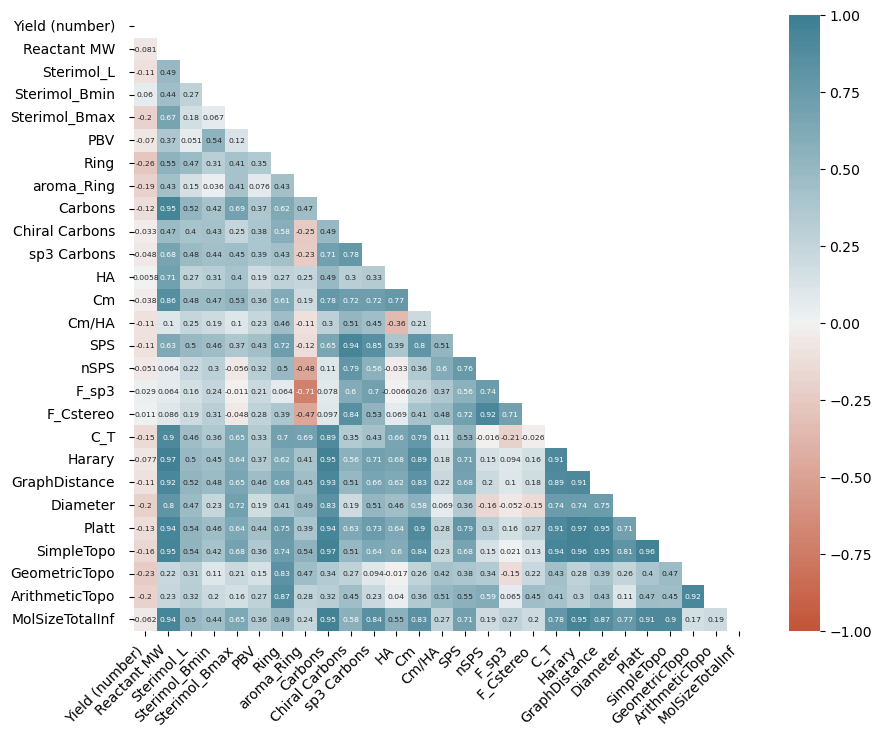

In [31]:
unnecessary_columns = ['Reaction', 'Reactant', 'Product', 'Reagent', 'Catalyst',
       'Solvent (Reaction Details)', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]', 'Yield', 'Reaction ID',
       'Links to Reaxys', 'Reaction: Links to Reaxys', 'References',
        'Reactant SMILES', 'Product SMILES', 'Change_MW',
       'Largest Reactant MW', 'change in C-O single bond',
       'change in C=O double bond', 'Procedure', 'Reaction Map',
       'Reactant smiles map', 'Product smiles map', 'C_idx', 'O_idx', 'Sterimol parameters']
df_reactants_toplot = data_getFeatures_Reactants.drop(columns=unnecessary_columns)
corr = df_reactants_toplot.corr()

# Upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Thhe heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    annot_kws={"size": 5.5}  
)

# Customize 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Optional: set y-tick labels rotation
ax = plt.gca()  
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
# ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

plt.show()

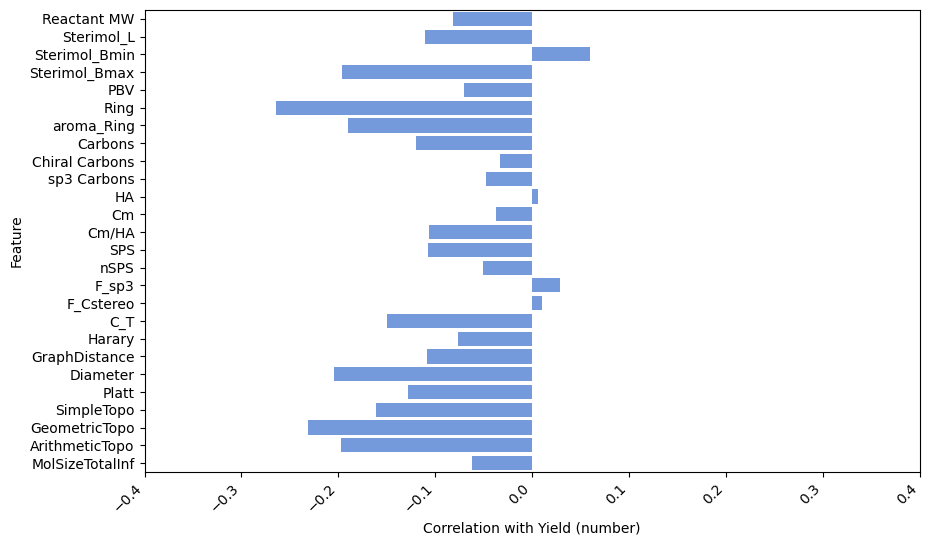

In [30]:
# Extract correlations with 'Yield (number)'
yield_corr = corr['Yield (number)'].drop('Yield (number)')  # Drop 'Yield (number)' to exclude self-correlation
yield_corr_df = pd.DataFrame({
    'Feature': yield_corr.index,
    'Correlation': yield_corr.values
})

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=yield_corr_df, y='Feature', x='Correlation', color = 'cornflowerblue')
ax.set_xlim(-0.4, 0.4)
# Customize plot
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('Feature')
plt.xlabel('Correlation with Yield (number)')
# plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [36]:
data_getFeatures_Reactants.to_excel('Reactant_features.xlsx', index = False)

--------
See if changing in features between reactant and product affects the correlation

In [12]:
same_colums =['Reaction',
 'Reactant',
 'Product',
 'Reagent',
 'Catalyst',
 'Solvent (Reaction Details)',
 'Time (Reaction Details) [h]',
 'Temperature (Reaction Details) [C]',
 'Yield',
 'Links to Reaxys',
 'Reaction: Links to Reaxys',
 'References',
 'Reactant SMILES',
 'Product SMILES',
 'Change_MW',
 'Largest Reactant MW',
 'change in C-O single bond',
 'change in C=O double bond',
 'Procedure',
 'Reactant MW',
 'Reaction Map',
 'Reactant smiles map',
 'Product smiles map',
 'C_idx',
 'O_idx']
data_Reactants = data_getFeatures_Reactants.drop(columns= same_colums + ['Sterimol parameters','Sterimol_L', 'Sterimol_Bmin', 'Sterimol_Bmax', 'PBV'])
data_Product = data_getFeatures_Product.drop(columns=same_colums)
 
data_getFeatures = pd.merge(data_Reactants, data_Product, on=['Reaction ID', 'Yield (number)'], how='inner')

# Function to generate new column names
def rename_columns(col):
    if '_x' in col:
        return re.sub(r'_x$', '_reactant', col)
    elif '_y' in col:
        return re.sub(r'_y$', '_product', col)
    return col

# Apply the renaming function
data_getFeatures.rename(columns=lambda x: rename_columns(x), inplace=True)

# Calculate features' changing after reaction
product_cols = [col for col in data_getFeatures.columns if col.endswith('_product')]
reactant_cols = [col for col in data_getFeatures.columns if col.endswith('_reactant')]

# Create new columns for changes
for prod_col in product_cols:
    base_name = prod_col.replace('_product', '')
    react_col = f'{base_name}_reactant'
    
    if react_col in data_getFeatures.columns:
        change_col = f'{base_name}_change'
        data_getFeatures[change_col] = data_getFeatures[prod_col] - data_getFeatures[react_col]
data_getFeatures

,Reaction ID,Yield (number),Ring_reactant,aroma_Ring_reactant,Carbons_reactant,Chiral Carbons_reactant,sp3 Carbons_reactant,HA_reactant,Cm_reactant,Cm/HA_reactant,...,F_Cstereo_change,C_T_change,Harary_change,GraphDistance_change,Diameter_change,Platt_change,SimpleTopo_change,GeometricTopo_change,ArithmeticTopo_change,MolSizeTotalInf_change
0,38244374,82.0,2,2,19,1,5,4,183.022806,45.755702,...,0.052632,-40.096612,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,13.737659
1,46506389,79.0,3,3,16,0,1,5,198.271835,39.654367,...,0.062500,-40.806242,-4.263256e-14,0.0,0.0,0,0.0,0.0,0.0,13.059900
2,34623882,91.0,3,3,16,0,1,4,180.242087,45.060522,...,0.062500,-40.397941,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,13.059900
3,34623878,80.0,3,3,16,0,1,5,198.271835,39.654367,...,0.062500,-40.806242,-4.263256e-14,0.0,0.0,0,0.0,0.0,0.0,13.059900
4,34623890,92.0,3,3,17,0,2,5,210.996975,42.199395,...,0.058824,-40.938171,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,13.380912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,2104996,95.0,1,1,8,0,1,4,96.442972,24.110743,...,0.125000,-34.720411,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,11.528043
902,1985375,80.0,1,1,12,0,3,1,80.264663,80.264663,...,0.083333,-34.720411,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,12.499486
903,578384,64.0,1,1,8,0,1,2,77.124485,38.562242,...,0.125000,-34.936928,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,11.223754
904,2532675,92.0,0,0,9,1,5,3,115.604513,38.534838,...,0.111111,-30.360032,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,12.394505


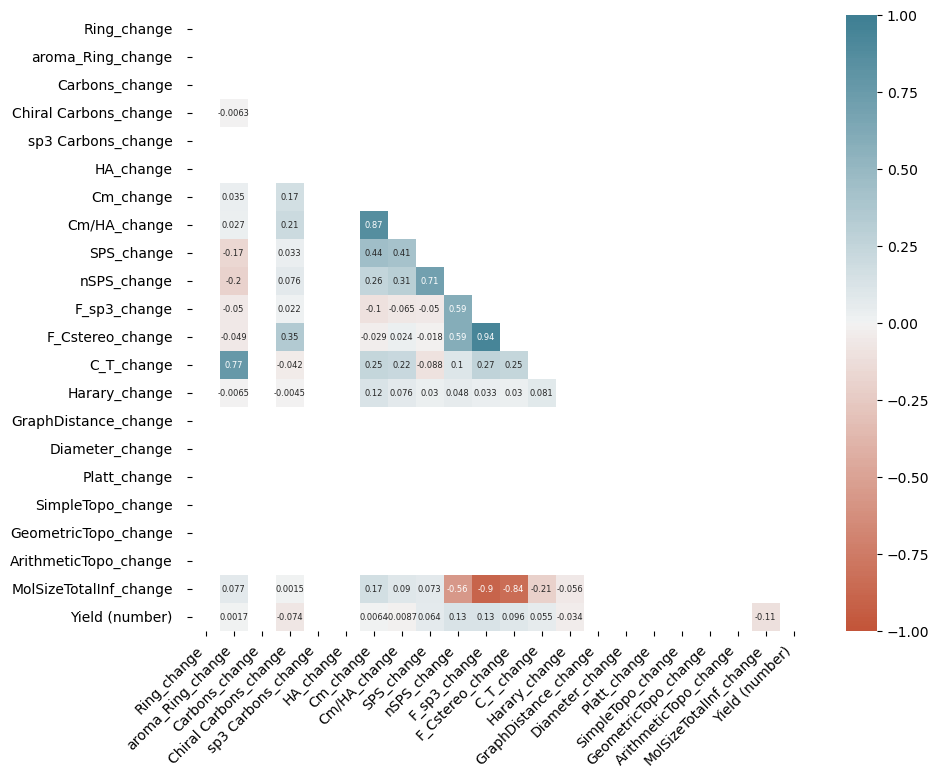

In [32]:
change_columns = [col for col in data_getFeatures.columns if col.endswith('_change')]

# Compute the correlation matrix
df_change = data_getFeatures[change_columns + ['Yield (number)']]
corr = df_change.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create the heatmap with the mask and smaller tick labels
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    mask=mask,  # Apply the mask
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    annot_kws={"size": 6}  # Size of the annotations
)

# Set smaller tick label size
ax.tick_params(axis='both', which='major', labelsize=10)

# Rotate tick labels if necessary
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Optional: set y-tick labels rotation

# Customize 
ax = plt.gca()  
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
# ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

plt.show()

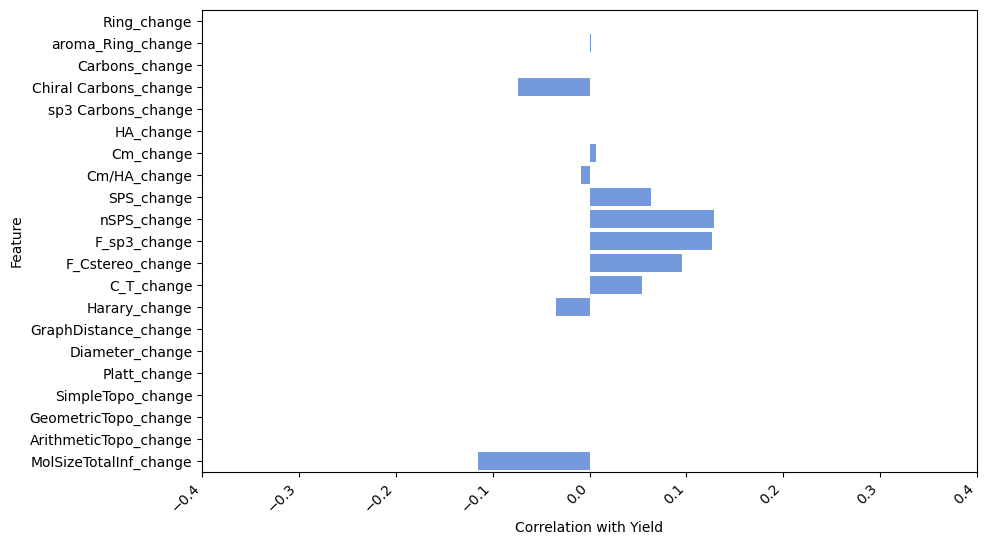

In [33]:
# Extract correlations with 'Yield (number)'
yield_corr = corr['Yield (number)'].drop('Yield (number)')  # Drop 'Yield (number)' to exclude self-correlation
yield_corr_df = pd.DataFrame({
    'Feature': yield_corr.index,
    'Correlation': yield_corr.values
})

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=yield_corr_df, y='Feature', x='Correlation', color = 'cornflowerblue')
ax.set_xlim(-0.4, 0.4)
# Customize plot
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('Feature')
plt.xlabel('Correlation with Yield')
# plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()